<a href="https://colab.research.google.com/github/lssds2024/lssds2024/blob/main/TimeSeries/DLforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Modified by FBB for LSDSS 2024

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

YOU WILL HAVE TO BUILD THE MODELS IN THE CORRESPONDING CELLS, WHERE THERE IS MISSING CODE YOU WILL SEE ELIIPSES: e.g. `linear = ...`

The key is in the file called models in the LSDSS24 repo TimeSeries folder



This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Recurrent Neural Networks (RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.


# Table of content



*   Setup
*   The weather dataset
    * Inspect and cleanup
    * Split the data
    * Normalize the data
* Data windowing
    * Indexes and offsets
    * Split
    * Plot
    * Create tf.data.Datasets

* MODELS
    * Baseline
    * lets first build some machinery to run NN models
    * Linear model
        * feature importance
    * MLP
    * Multi-step MLP
        * FOR YOU TO DO!
    * Recurrent neural network
        * FOR YOU TO DO!
    * LSTM
    * Performance

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, Reshape

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
# Slice [start:stop:step], starting from index 5 take every 6th record to get hourly predictions
df = df[5::6]
#separate time column
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Let's take a glance at the data. Here are the first few rows:

In [7]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

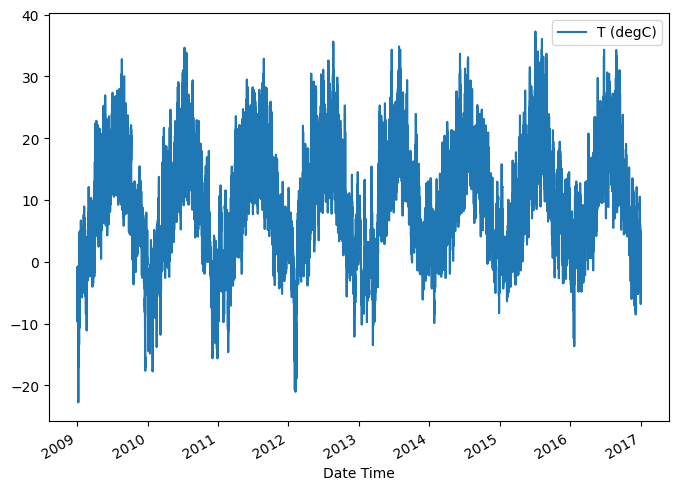

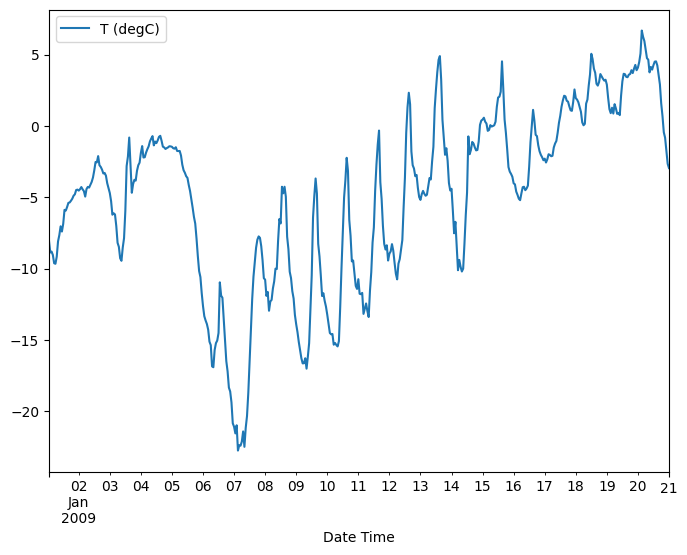

In [8]:
plot_cols = ['T (degC)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [10]:
df.isna().sum()

,0
p (mbar),0
T (degC),0
Tpot (K),0
Tdew (degC),0
rh (%),0
VPmax (mbar),0
VPact (mbar),0
VPdef (mbar),0
sh (g/kg),0
H2OC (mmol/mol),0


In [11]:
df.drop(["wv (m/s)","max. wv (m/s)"], axis=1, inplace=True)

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data


NOTE: normalize all data basedon on the training statistical properties!!

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
train_mean

,0
p (mbar),988.656343
T (degC),9.108207
Tpot (K),283.194958
Tdew (degC),4.599605
rh (%),75.906008
VPmax (mbar),13.355098
VPact (mbar),9.356960
VPdef (mbar),3.998056
sh (g/kg),5.913550
H2OC (mmol/mol),9.466371


In [15]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),49063.0,1.807385e-16,1.0,-9.045695,-0.609384,0.054674,0.654857,2.913378
T (degC),49063.0,-1.714699e-16,1.0,-3.682079,-0.706903,0.009450,0.720027,3.066661
Tpot (K),49063.0,9.500357e-16,1.0,-3.707266,-0.693998,0.013186,0.712347,3.041354
Tdew (degC),49063.0,2.780592e-17,1.0,-4.216645,-0.669739,0.051690,0.753039,2.647686
rh (%),49063.0,-6.812451e-16,1.0,-3.746587,-0.658157,0.198969,0.815084,1.455361
VPmax (mbar),49063.0,-2.780592e-17,1.0,-1.609554,-0.750526,-0.222892,0.533469,5.846190
VPact (mbar),49063.0,-2.548876e-16,1.0,-2.030996,-0.778697,-0.156112,0.668457,4.489514
VPdef (mbar),49063.0,-9.268641e-18,1.0,-0.829861,-0.657581,-0.383594,0.268164,7.842254
sh (g/kg),49063.0,-1.204923e-16,1.0,-2.022853,-0.776247,-0.154815,0.665025,4.550843
H2OC (mmol/mol),49063.0,1.853728e-16,1.0,-2.031986,-0.776133,-0.154076,0.665163,4.524268


## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 12)
Inputs shape: (3, 6, 12)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [21]:
w2.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                color='SteelBlue', label='Labels', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', label='Predictions',
                  c='IndianRed', s=64)
      plt.plot(self.label_indices, predictions[n, :, label_col_index],
                  color="k", alpha=0.5)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

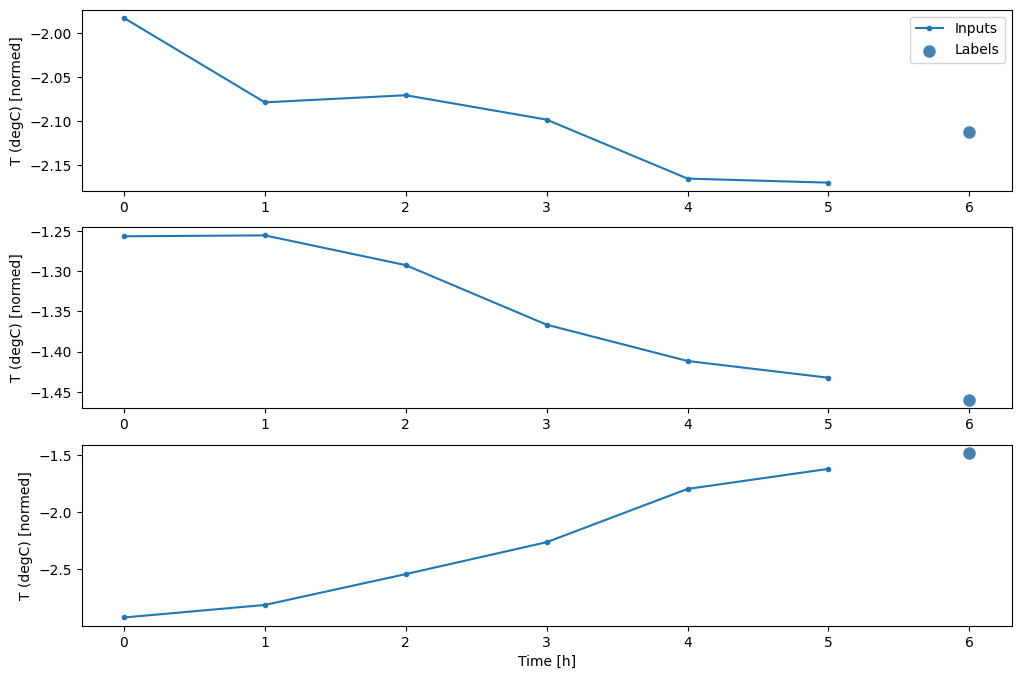

In [23]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [26]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [27]:
w2.test.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [28]:
w2.val.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [29]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [31]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 12)
Labels shape (batch, time, features): (32, 1, 1)


# MODELS

### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [32]:
class Baseline(tf.keras.Model):
  ...

Instantiate and evaluate this model:

In [33]:
baseline = Baseline()

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0802


In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [35]:
#check that input and output dimensions make sense for the plots
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

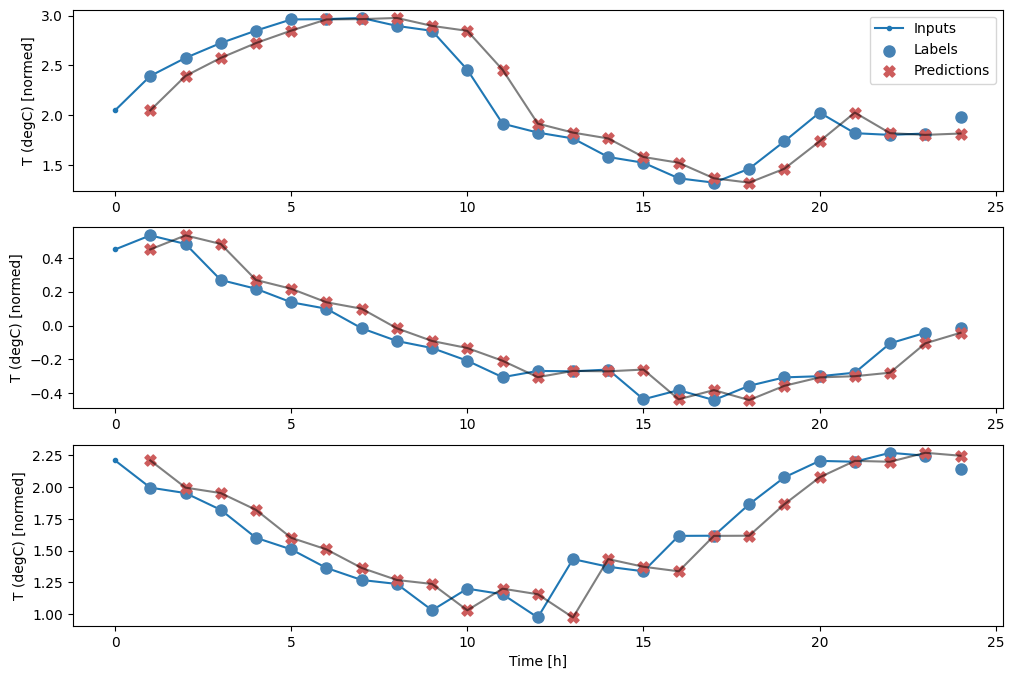

In [36]:
wide_window.plot(baseline)

In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### lets first build some machinery to run NN models

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [38]:
linear = .......... # lets build a linear regression in tensor flow


In [39]:
#check that input and output dimensions make sense
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

Train the model and evaluate its performance:

In [40]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.4826 - mean_absolute_error: 0.5065 - val_loss: 0.0235 - val_mean_absolute_error: 0.1160
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0218 - mean_absolute_error: 0.1107 - val_loss: 0.0139 - val_mean_absolute_error: 0.0844
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0152 - mean_absolute_error: 0.0887 - val_loss: 0.0136 - val_mean_absolute_error: 0.0835
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0878 - val_loss: 0.0134 - val_mean_absolute_error: 0.0831
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0872 - val_loss: 0.0133 - val_mean_absolute_error: 0.0819
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0867 - val_loss: 0.0132 - val_mean_absolute_error: 0.0817
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0145 - mean_absolute_e

In [41]:
#make predictions to plot
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

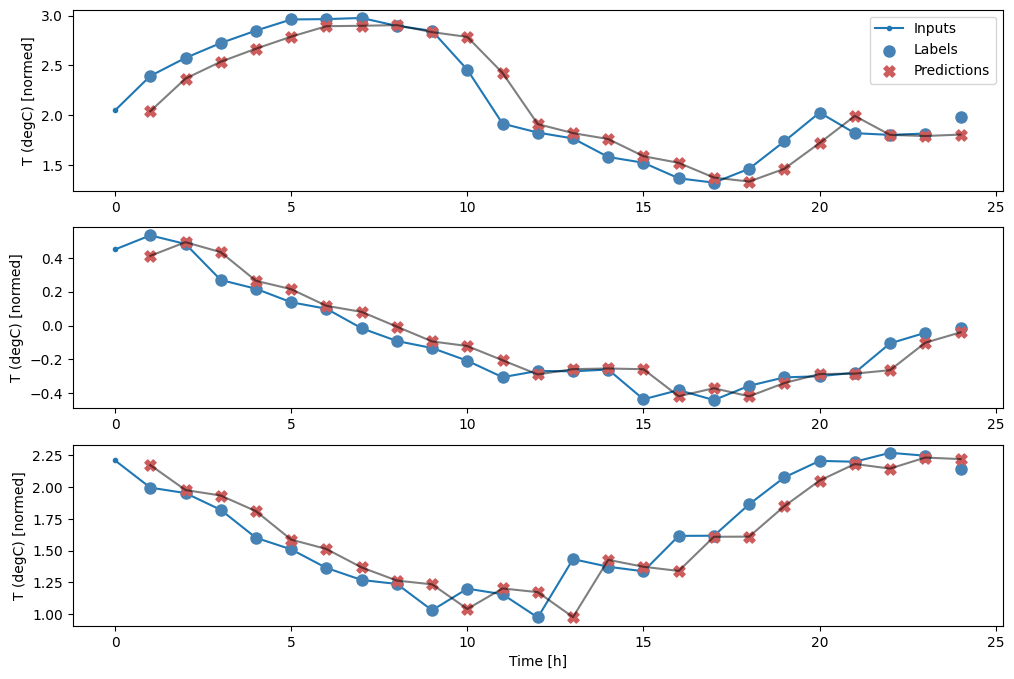

In [42]:
wide_window.plot(linear)

#### feature importance

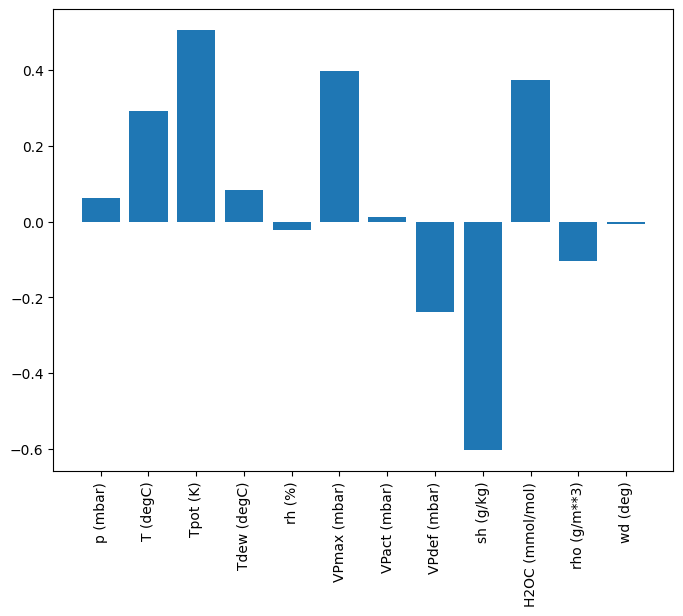

In [43]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### MLP


In [44]:
mlp = ... # 64 neurons in each of 2 hidden layers, predict 1 value, relu activation on hidden layers


In [46]:
#check that input and output dimensions make sense
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', mlp(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


In [45]:

history = compile_and_fit(mlp, single_step_window)

val_performance['MLP'] = mlp.evaluate(single_step_window.val, return_dict=True)
performance['MLP'] = mlp.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0933 - mean_absolute_error: 0.1320 - val_loss: 0.0127 - val_mean_absolute_error: 0.0839
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0135 - mean_absolute_error: 0.0857 - val_loss: 0.0129 - val_mean_absolute_error: 0.0829
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0841 - val_loss: 0.0128 - val_mean_absolute_error: 0.0829
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0823


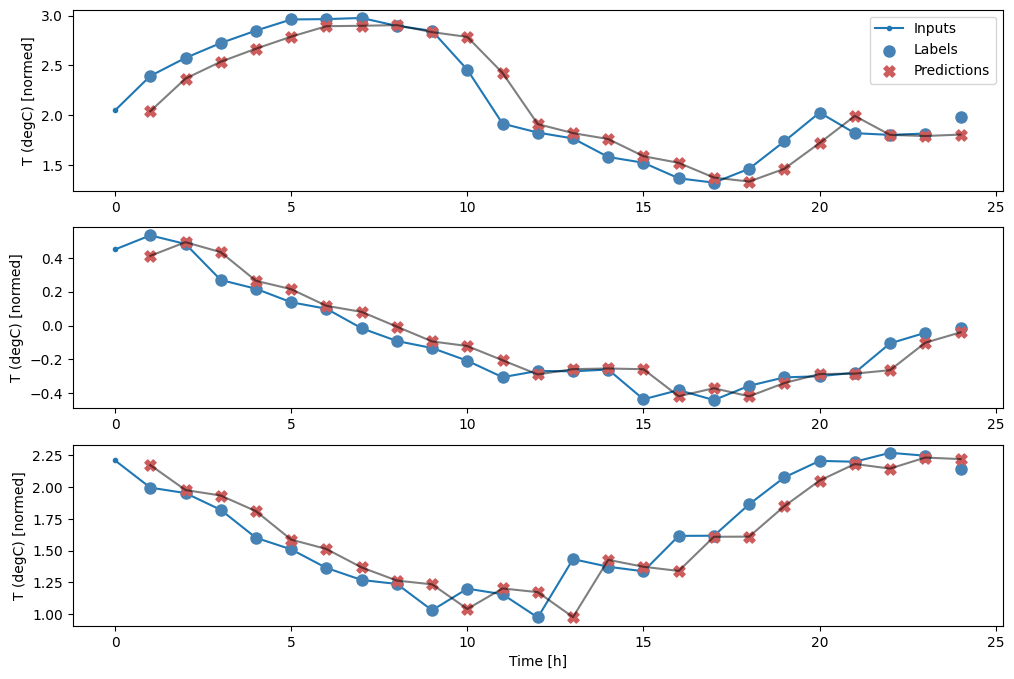

In [47]:
wide_window.plot(linear)

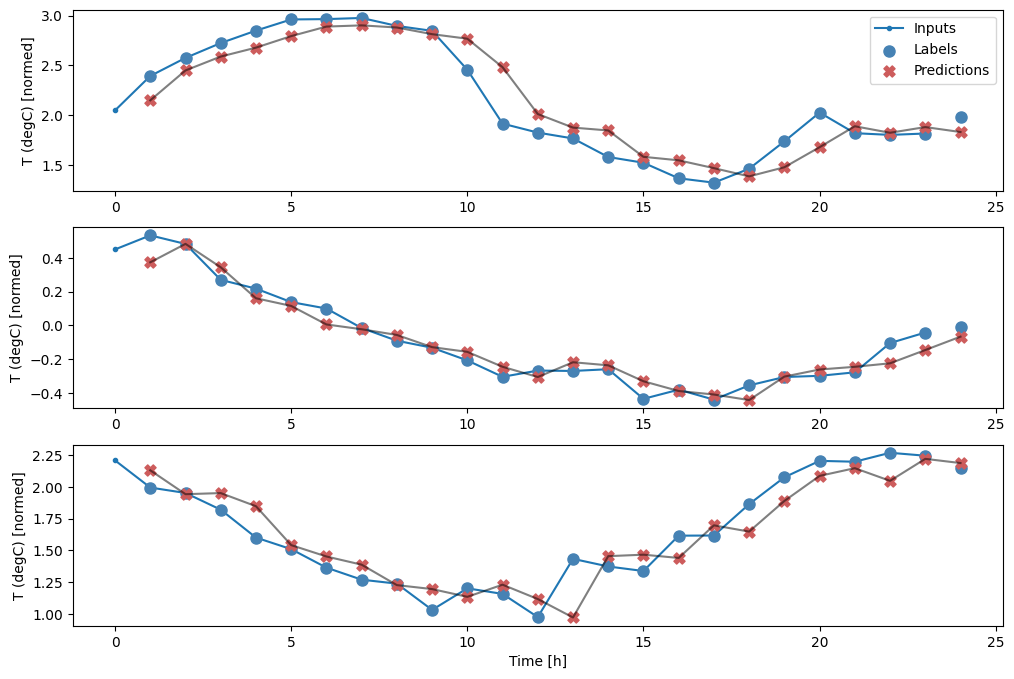

In [48]:
wide_window.plot(mlp)

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [49]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [50]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

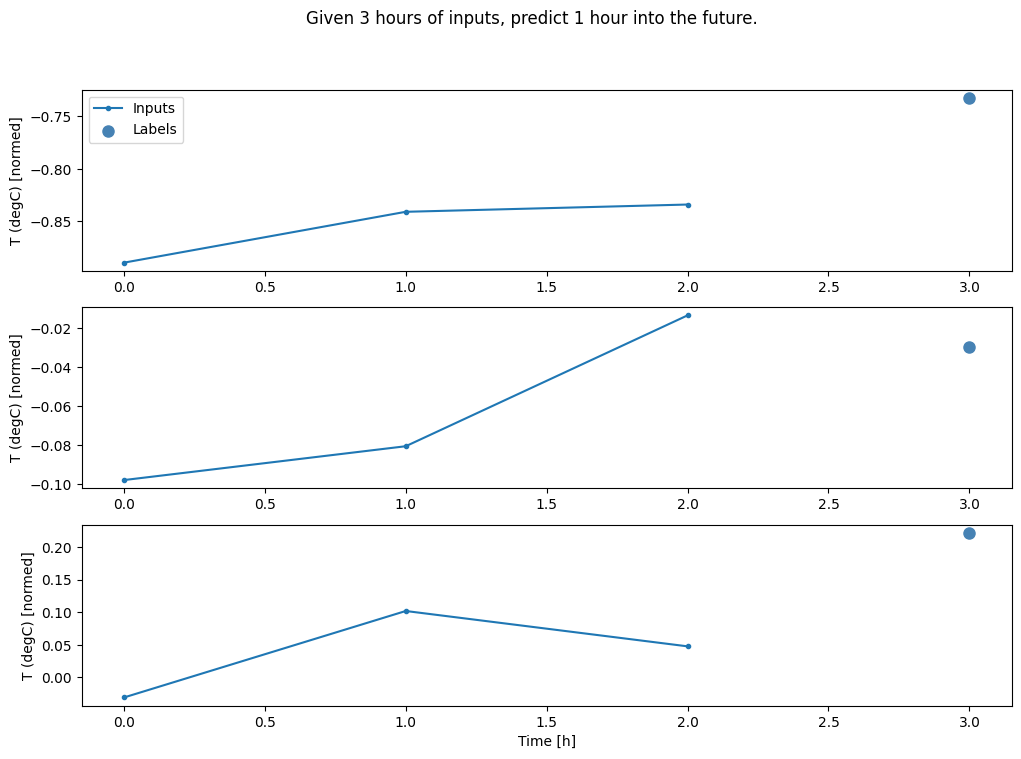

In [51]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [54]:
multi_step_mlp = ... # 2 hidden layers of 32 neurons each,  preduct 1 value ,but how do you pass the 2d input to the first


In [55]:
#check that input and output dimensions make sense
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_mlp(conv_window.example[0]).shape)

Input shape: (32, 3, 12)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_mlp, conv_window)

IPython.display.clear_output()
val_performance['sequence MLP'] = multi_step_mlp.evaluate(conv_window.val, return_dict=True)
performance['sequence MLP'] = multi_step_mlp.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0118 - mean_absolute_error: 0.0857


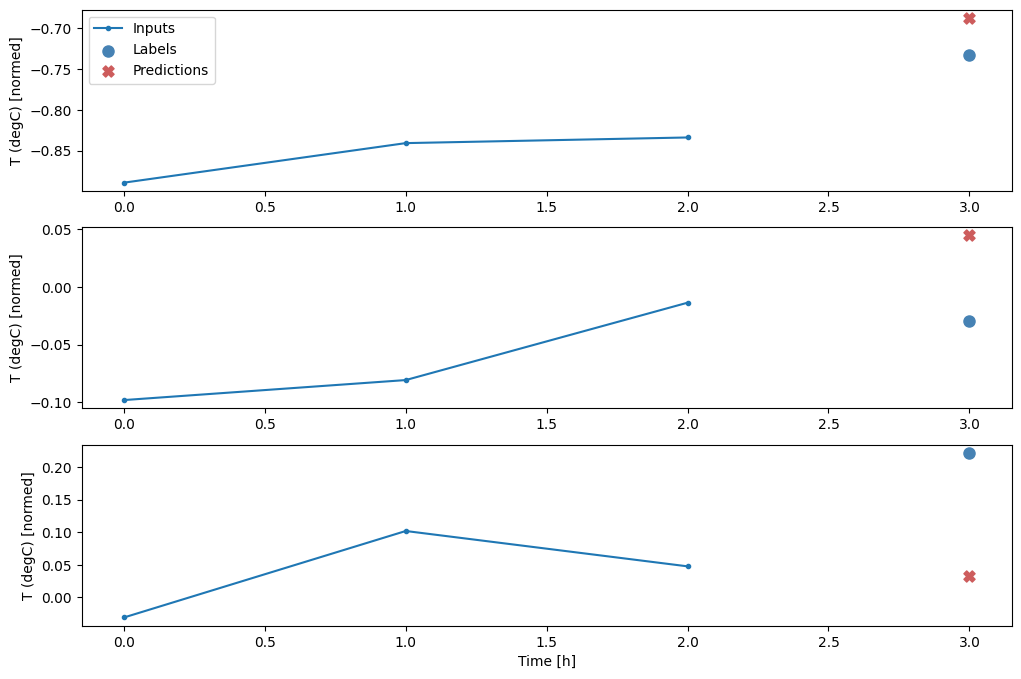

In [57]:
conv_window.plot(multi_step_mlp)

#### FOR YOU TO DO!
how do you build a function to plot this output?

### Recurrent neural network



An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [58]:
rnn_model = ...# hidden: SimpleRNN layer with 128 neurons


In [59]:
history = compile_and_fit(rnn_model, wide_window)

IPython.display.clear_output()
val_performance['RNN'] = rnn_model.evaluate(wide_window.val, return_dict=True)
performance['RNN'] = rnn_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1219 - mean_absolute_error: 0.2698


In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', rnn_model(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 1)


#### FOR YOU TO DO!
how do you build a function to plot this output?

## LSTM

In [63]:
lstm_model = ... # hidden: lstm layer with 32 neurons

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


In [65]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0578


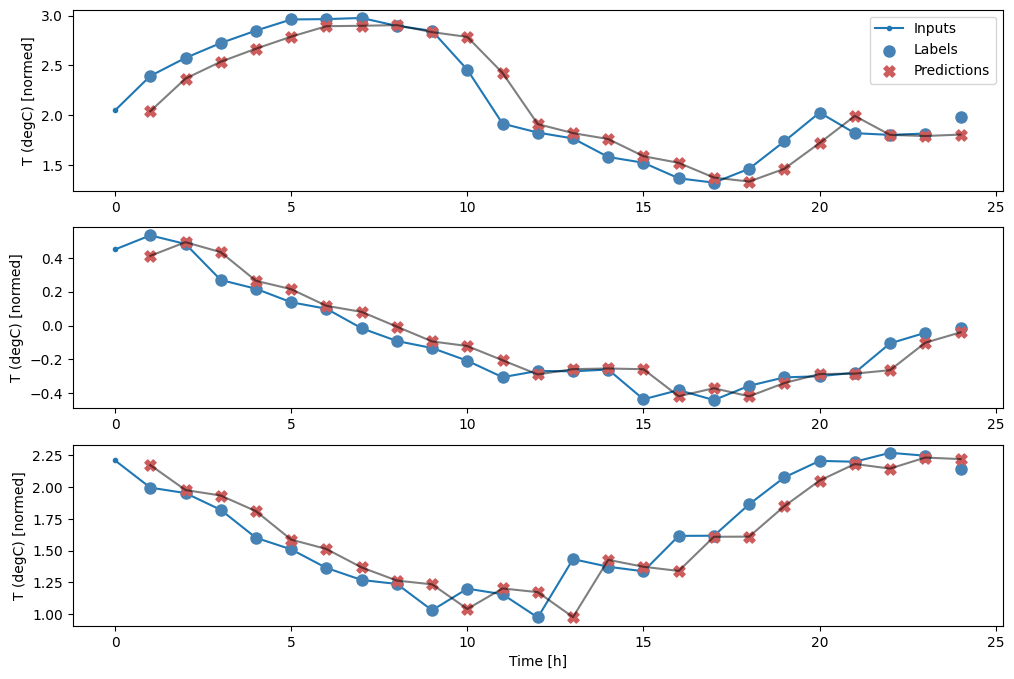

In [66]:
wide_window.plot(linear)

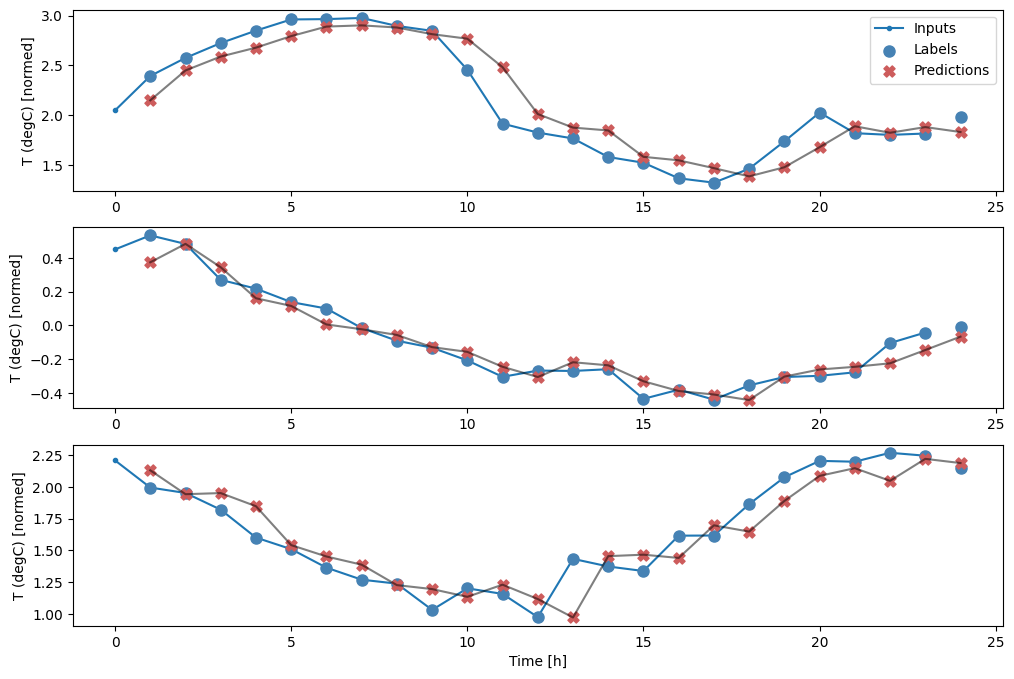

In [67]:
wide_window.plot(mlp)

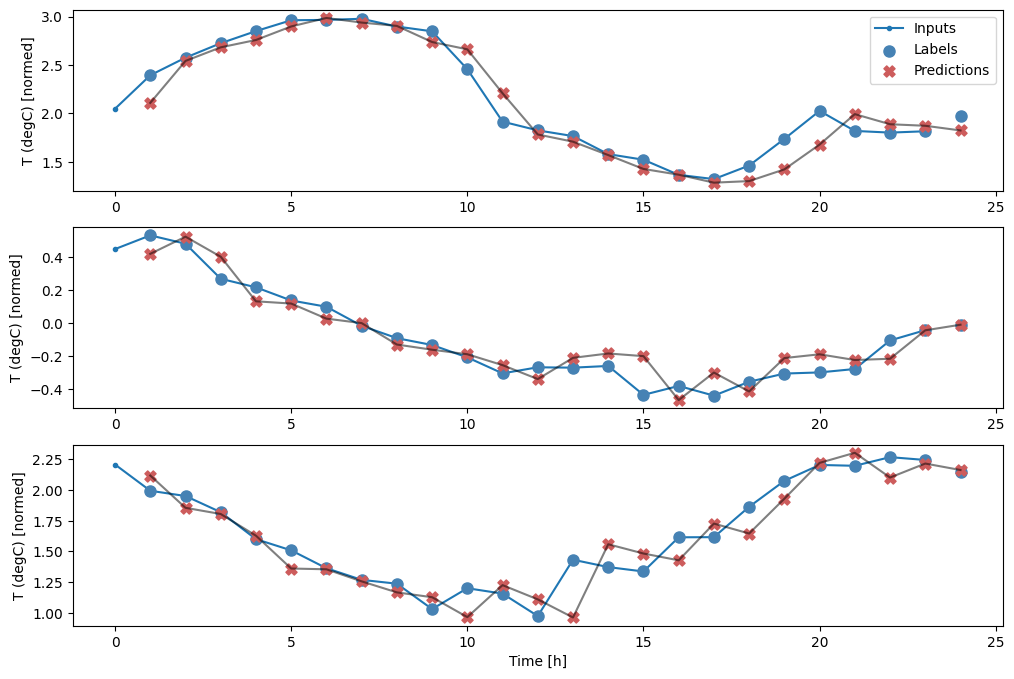

In [68]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

In [73]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [74]:
val_performance

{'Baseline': {'loss': 0.012845649383962154,
  'mean_absolute_error': 0.07846630364656448},
 'Linear': {'loss': 0.012656915932893753,
  'mean_absolute_error': 0.08006145805120468},
 'MLP': {'loss': 0.012837223708629608,
  'mean_absolute_error': 0.08291108161211014},
 'sequence MLP': {'loss': 0.011782923713326454,
  'mean_absolute_error': 0.0855807214975357},
 'RNN': {'loss': 0.12184283882379532,
  'mean_absolute_error': 0.26955416798591614},
 'LSTM': {'loss': 0.006977316923439503,
  'mean_absolute_error': 0.05766570568084717}}

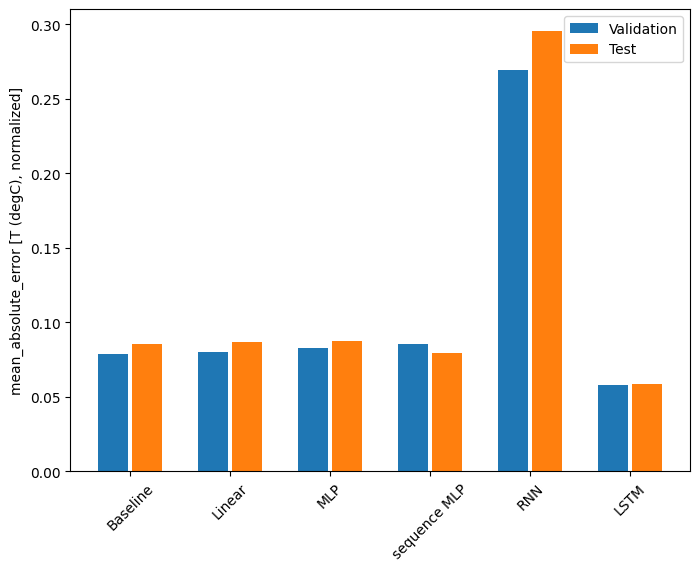

In [75]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0867
MLP         : 0.0873
sequence MLP: 0.0795
RNN         : 0.2954
LSTM        : 0.0583
